In [1]:
# Type of GPU I will be using
!nvidia-smi

Thu Apr 11 16:47:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install accelerate==0.28.0
import accelerate
from transformers import Trainer, TrainingArguments

print(accelerate.__version__)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=500,
    eval_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 7.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [3]:
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

# Assignment 3

*Part 1: Develop a sentiment classification model with 1 hot-encoding or Tf-idf.*

In [4]:
import os
os.getcwd()

'/content'

In [5]:
!unzip /content/TweetData.zip

Archive:  /content/TweetData.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [6]:
import pandas as pd
columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
# Load the training data from the extracted files
df = pd.read_csv("/content/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", names = columns)

## Data Visualization

In [7]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
df.tail(5)

,target,ids,date,flag,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [9]:
# Number of null values
import numpy as np
np.sum(df.isnull().any(axis=1))

0

In [10]:
print('Number of columns:  ', len(df.columns))
print('Number of rows:  ', len(df))

Number of columns:   6
Number of rows:   1600000


In [11]:
# Number of unique target values
print('Number of unique variables:  ',df['target'].nunique())
print('What the variables are:  ',df['target'].unique())

Number of unique variables:   2
What the variables are:   [0 4]


## Cleaning

In [12]:
# Simplifying data to the two columns we need
data=df[['text','target']]
# Replace positive values to 1 to make analysis easier to understand
data['target'] = data['target'].replace(4,1)

<ipython-input-12-a16ae5d35bfb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4,1)


In [13]:
# Print out two new unique target variables
data['target'].unique()

array([0, 1])

In [14]:
# Separating the positive and negative values
pos = data[data['target'] == 1]
neg = data[data['target'] == 0]

# Taking a subset of the data so we can run it easily
pos = pos.iloc[:int(20000)]
neg = neg.iloc[:int(20000)]

In [15]:
pos.head(5)

,text,target
800000,I LOVE @Health4UandPets u guys r the best!!,1
800001,im meeting up with one of my besties tonight! ...,1
800002,"@DaRealSunisaKim Thanks for the Twitter add, S...",1
800003,Being sick can be really cheap when it hurts t...,1
800004,@LovesBrooklyn2 he has that effect on everyone,1


In [16]:
neg.head(5)

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [17]:
# Combining them back
data = pd.concat([pos, neg])
data.tail(5)

,text,target
19995,"Not much time off this weekend, work trip to M...",0
19996,One more day of holidays,0
19997,feeling so down right now .. i hate you DAMN H...,0
19998,"geez,i hv to READ the whole book of personalit...",0
19999,I threw my sign at donnie and he bent over to ...,0


In [18]:
# Making all text lowercase
data['text']=data['text'].str.lower()
data['text'].tail()

19995    not much time off this weekend, work trip to m...
19996                            one more day of holidays 
19997    feeling so down right now .. i hate you damn h...
19998    geez,i hv to read the whole book of personalit...
19999    i threw my sign at donnie and he bent over to ...
Name: text, dtype: object

In [19]:
# Creating a list of stop words to take out
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

stopwords = set(stopwordlist)
def clean_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopwords])
data['text'] = data['text'].apply(lambda text: clean_stopwords(text))
data['text'].head()

800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [20]:
# Removing punctuation
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def clean_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
data['text']= data['text'].apply(lambda x: clean_punctuations(x))
data['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [21]:
import re
# Cleaning & removing repeating characters
def clean_repeats(text):
    return re.sub(r'(.)1+', r'1', text)
data['text'] = data['text'].apply(lambda x: clean_repeats(x))
data['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [22]:
# Taking out URLS
def clean_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
data['text'] = data['text'].apply(lambda x: clean_URLs(x))
data['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [23]:
# Taking out numbers
def clean_numbers(data):
    return re.sub('[0-9]+', '', data)
data['text'] = data['text'].apply(lambda x: clean_numbers(x))
data['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

# Preprocessing

In [24]:
# Feature extraction
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
data['text'] = data['text'].apply(tokenizer.tokenize)
data['text'].head()

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

In [25]:
# Stemming on the words
import nltk
from nltk.stem import PorterStemmer
st = nltk.PorterStemmer()
def stem_text(dataset):
    text = [st.stem(word) for word in dataset]
    return dataset
data['text']= data['text'].apply(lambda x: stem_text(x))
data['text'].head()

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

In [26]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lm = nltk.WordNetLemmatizer()
def lemmatizer(dataset):
    text = [lm.lemmatize(word) for word in dataset]
    return dataset
data['text'] = data['text'].apply(lambda x: lemmatizer(x))
data['text'].head()

[nltk_data] Downloading package wordnet to /root/nltk_data...


800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

# Part 1. Develop a sentiment classification model with 1 hot-encoding or Tf-idf.

*Train the one hot encoder and Tf-idf tokenizer only on the train data.*

In [27]:
from sklearn.model_selection import train_test_split
X = data.text
y = data.target
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state = 26105111)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [28]:
X_train = X_train.astype(str).tolist()
X_test = X_test.astype(str).tolist()
y_train = y_train.astype(str).tolist()
y_test = y_test.astype(str).tolist()
X_val = X_val.astype(str).tolist()
y_val = y_val.astype(str).tolist()

*Create embedding of train, validation and test data*

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
# Fit the vectorizer to the training data
vectorizer.fit(X_train)
# Get the feature names
feature_names = vectorizer.get_feature_names_out()

print('No. of feature_words: ', len(feature_names))

No. of feature_words:  196067


In [30]:
# Transform the training data
X_train_transformed = vectorizer.transform(X_train)

# Transform the test data
X_test_transformed = vectorizer.transform(X_test)

In [31]:
def model_Evaluate(model, X):
  # Predict values for Test dataset
  y_pred = model.predict(X)
  # Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))
  # Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

*Train a classification model of your choice using embeddings and tune the hyperparameters (minimum 2 parameters need to be tuned)*

In [32]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'max_iter': [100, 500, 1000]
}

# Initialize the logistic regression model
LRmodel = LogisticRegression(n_jobs=-1)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=LRmodel, param_grid=param_grid, cv=5)
grid_search.fit(X_train_transformed, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
LRmodel_best = LogisticRegression(**best_params)
LRmodel_best.fit(X_train_transformed, y_train)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10)

In [33]:
print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'C': 10, 'max_iter': 100}


*Show the performance on the test data.*

              precision    recall  f1-score   support

           0       0.74      0.79      0.76       991
           1       0.78      0.73      0.75      1009

    accuracy                           0.76      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.76      0.76      0.76      2000



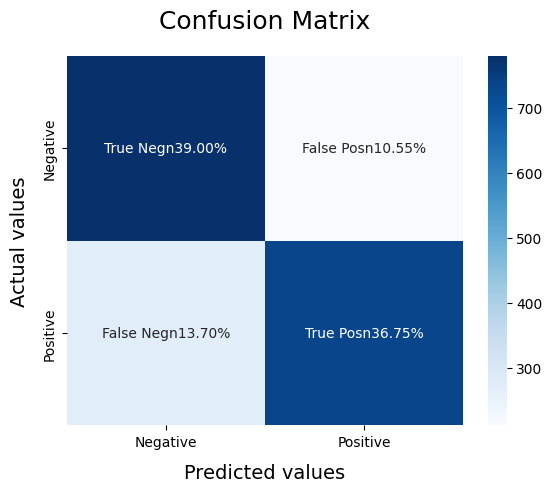

In [36]:
# Evaluate the model
model_Evaluate(LRmodel_best, X_test_transformed)

# Part 2. Develop a sentiment classification model using word2vec/glove.

*Either train a word2vec model or load a pre-trained model (glove-twitter-25)*

In [37]:
import gensim.downloader as api
model = api.load("glove-twitter-25")

[==================================================] 100.0% 104.8/104.8MB downloaded


*Create embedding of train, validation and test data*

In [38]:
# Convert text data to embeddings
def text_to_embeddings(text, model):
    embeddings = []
    for word in text:
        if word in model:
            embeddings.append(model[word])
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(model.vector_size)

X_train_embedded = [text_to_embeddings(text, model) for text in X_train]
X_test_embedded = [text_to_embeddings(text, model) for text in X_test]

*Train a classification model of your choice and tune the hyperparameters & Show the performance on the test data.*

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

              precision    recall  f1-score   support

           0       0.58      0.59      0.59       991
           1       0.59      0.58      0.58      1009

    accuracy                           0.59      2000
   macro avg       0.59      0.59      0.59      2000
weighted avg       0.59      0.59      0.59      2000



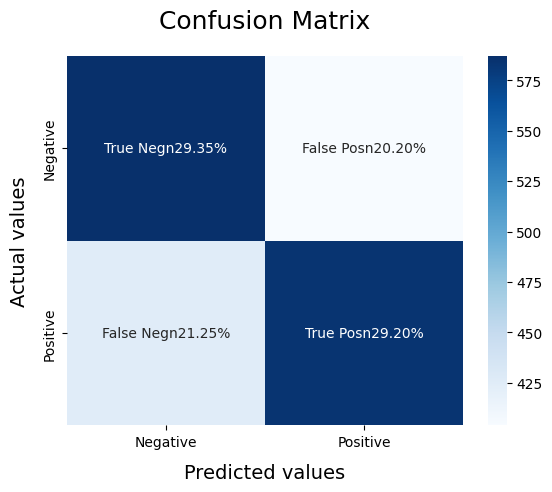

In [39]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'max_iter': [100, 500, 1000]
}

# Initialize the logistic regression model
LRmodel2 = LogisticRegression()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=LRmodel2, param_grid=param_grid, cv=5)
grid_search.fit(X_train_embedded, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
LRmodel_best2 = LogisticRegression(**best_params)
LRmodel_best2.fit(X_train_embedded, y_train)

# Evaluate the model
model_Evaluate(LRmodel_best2, X_test_embedded)

# Part 3. Develop a sentiment classification model using transformer

In [40]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [42]:
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# Split the dataset into train, validation, and test sets
#train_val_df, test_df = train_test_split(data, test_size=0.1, random_state=42)
#train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=42)

class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Convert labels to numeric data types
y_train = list(map(int, y_train))
y_val = list(map(int, y_val))
y_test = list(map(int, y_test))

train_dataset = SentimentDataset(X_train, y_train)
val_dataset = SentimentDataset(X_val, y_val)
test_dataset = SentimentDataset(X_test, y_test)

# Encode the datasets
def encode_dataset(data, labels):
    encodings = tokenizer(data, truncation=True, padding=True)
    return SentimentDataset(encodings, labels)

train_dataset = encode_dataset(X_train, y_train)
val_dataset = encode_dataset(X_val, y_val)
test_dataset = encode_dataset(X_test, y_test)

*Fine-tune a small scale transformer model (e.g. BERT, GPT2 small) for the sentiment classification task*

In [45]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# Determine the number of unique labels
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)


def model_eval(p):
    predictions, labels = p
    pred_labels = np.argmax(predictions, axis=1)
    # Evaluate model
    accuracy = accuracy_score(labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, pred_labels, average='weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=model_eval
)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.589200,0.545296,0.738000,0.760523,0.738000,0.732550
1000,0.500500,0.498589,0.767789,0.768034,0.767789,0.767704
1500,0.465900,0.464622,0.787684,0.788952,0.787684,0.787392
2000,0.430300,0.469022,0.789684,0.789699,0.789684,0.789673
2500,0.370800,0.490361,0.792737,0.792740,0.792737,0.792738
3000,0.386200,0.453062,0.795158,0.795172,0.795158,0.795160
3500,0.369400,0.461866,0.794105,0.794339,0.794105,0.794040
4000,0.272900,0.554989,0.795579,0.795578,0.795579,0.795578
4500,0.241600,0.596676,0.794526,0.794651,0.794526,0.794486
5000,0.226600,0.605710,0.793684,0.793876,0.793684,0.793670


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.589200,0.545296,0.738000,0.760523,0.738000,0.732550
1000,0.500500,0.498589,0.767789,0.768034,0.767789,0.767704
1500,0.465900,0.464622,0.787684,0.788952,0.787684,0.787392
2000,0.430300,0.469022,0.789684,0.789699,0.789684,0.789673
2500,0.370800,0.490361,0.792737,0.792740,0.792737,0.792738
3000,0.386200,0.453062,0.795158,0.795172,0.795158,0.795160
3500,0.369400,0.461866,0.794105,0.794339,0.794105,0.794040
4000,0.272900,0.554989,0.795579,0.795578,0.795579,0.795578
4500,0.241600,0.596676,0.794526,0.794651,0.794526,0.794486
5000,0.226600,0.605710,0.793684,0.793876,0.793684,0.793670


TrainOutput(global_step=5346, training_loss=0.37494914165115784, metrics={'train_runtime': 1766.132, 'train_samples_per_second': 48.411, 'train_steps_per_second': 3.027, 'total_flos': 3871178617950000.0, 'train_loss': 0.37494914165115784, 'epoch': 3.0})

*Show the performance on the test data.*

In [46]:
test_predictions = trainer.predict(test_dataset)
print("Test Performance\n", classification_report(test_predictions.label_ids, test_predictions.predictions.argmax(axis=1)))

Test Performance
               precision    recall  f1-score   support

           0       0.78      0.79      0.78       991
           1       0.79      0.78      0.78      1009

    accuracy                           0.78      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.78      0.78      0.78      2000

